In [1]:
import csv, glob, os, sys, numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import timeit, math, inspect
from scipy.optimize import curve_fit
from scipy import optimize
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy import signal
from numpy import NaN, Inf, arange, isscalar, asarray, array
import numpy.polynomial.polynomial as poly

plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15 #make size of axis tick labels larger

# DEFINE FITTING FUNCTIONS
def rsquared(y, fit): #r^2 value for quantification of fitting errors
    residuals = y - fit #find residuals 
    r_square_value = 1 - (np.sum(residuals**2) / np.sum((y-np.mean(y))**2)) #r^2 value
    return r_square_value

def linear(x, m, b):
    return m*x + b
linear.name = 'linear'

def quadratic(x, a, b, c):  # define variables in each function
    return a*x**2 + b*x + c
quadratic.name = 'quadratic'

def langmuir_isotherm(p, q, k): #p=pressure, qm=max adsorption capacity, k=Lamgmnuir constant
    return k*q*p/(1+k*p)
langmuir_isotherm.name = 'langmuir_isotherm'

def toth_isotherm(p, kt, t): #p=pressure, saturation loading, b = adsorption affinity, t = adsorbent heterogeneity
    return (kt*p)/((1+(kt*p)**t)**(1/t))
toth_isotherm.name = 'toth_isotherm'

def single_exponential(x, a, tau, x0, y0):
    return a*np.exp(-(x)/tau) + y0
single_exponential.name = 'single_exponential'

def double_exponential(x, a1, tau1, a2, tau2, y0):
    return a1 * np.exp(-(x) / tau1) + a2 * np.exp(-(x) / tau2) + y0
double_exponential.name = 'double_exponential'

func_vars = {'linear': ['m', 'b'], #make dictionary for variables of each function
            'quadratic': ['a', 'b', 'c'],
            'single_exponential': ['a', 'tau', 'y0'],
            'double_exponential': ['a1', 'tau1', 'a2', 'tau2', 'x0', 'y0'],
            'langmuir_isotherm': ['q', 'k'],
            'toth_isotherm': ['kt', 't']} 


filename='C:\\Users\\a6q\\Desktop\\SU8-ZnO\\su8-zno qcm mags.csv' #frequency filename
rawdata = pd.read_csv(filename)#, skiprows=698, header=0, error_bad_lines=False, sep='\s+') #read in file
print(rawdata)

        p  d16h2o  d8h2o   d4h2o  d0h2o  uv16h2o   uv8h2o  uv4h2o  uv0h2o  \
0   0.242   0.031  0.051  0.0110  0.004    0.031  0.06300  0.0254  0.0210   
1   2.380   0.099  0.137  0.0290  0.017    0.099  0.20600  0.0910  0.0798   
2   7.126   0.164  0.207  0.0445  0.034    0.183  0.33657  0.1430  0.1344   
3  14.147   0.212  0.266  0.0620  0.054    0.261  0.45100  0.1860  0.1740   
4  22.600   0.251  0.310  0.0830  0.074    0.339  0.53800  0.2130  0.1924   

     d16o2    d8o2    d4o2    d0o2  uv16o2    uv8o2   uv4o2    uv0o2  
0  0.01600  0.0210  0.0040  0.0033  0.0160  0.05570  0.0560  0.04130  
1  0.03000  0.0410  0.0140  0.0072  0.1045  0.15400  0.1429  0.12700  
2  0.04900  0.0633  0.0269  0.0118  0.2149  0.25200  0.2200  0.20668  
3  0.06770  0.0830  0.0350  0.0180  0.3140  0.33644  0.2825  0.25700  
4  0.08467  0.0980  0.0440  0.0240  0.3847  0.38820  0.3134  0.26550  


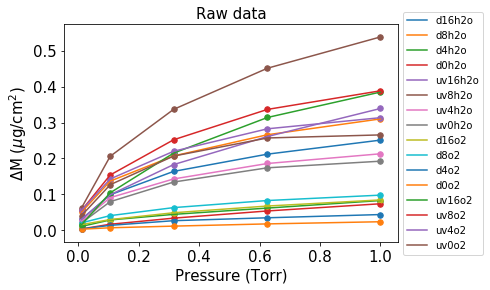

[ 0.02790712  0.10089636  0.16391044  0.21281519  0.24986497]
[ 0.04405289  0.13897447  0.21240889  0.26628843  0.30575806]
[ 0.00712632  0.02744922  0.04761591  0.06507362  0.07942856]
[ 0.0024161   0.0158136   0.03495634  0.05490554  0.07315485]
[ 0.01596187  0.09566499  0.1887528   0.268571    0.33072679]
[ 0.04216558  0.20528803  0.35107263  0.45452723  0.52538643]
[ 0.02723761  0.09031829  0.14305001  0.18386283  0.21490986]
[ 0.0243658   0.08182328  0.13065426  0.16886574  0.19815777]
[ 0.00964337  0.03188072  0.05196058  0.06860633  0.08196763]
[ 0.01615108  0.04370091  0.06563617  0.08278756  0.09610107]
[ 0.00384483  0.01472421  0.02580273  0.03563974  0.04389781]
[ 0.00160936  0.00690878  0.01284331  0.01842072  0.02328401]
[ 0.01571082  0.10480144  0.21576765  0.3118724   0.38590137]
[ 0.04108284  0.1597926   0.25926537  0.33243894  0.38527514]
[ 0.04957783  0.14859556  0.22265061  0.27621564  0.31516502]
[ 0.04582908  0.13262113  0.19750027  0.24486768  0.27963346]


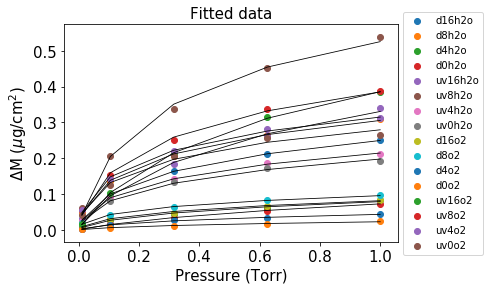

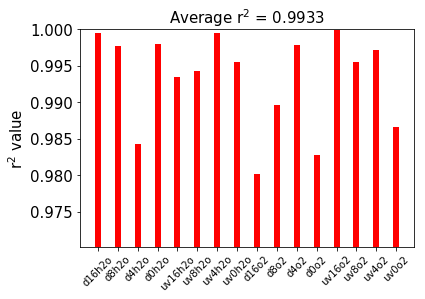

In [53]:
p = np.array(rawdata['p']) #make array of pressures
data = rawdata.drop('p', 1) #drop pressures from dataframe
names = list(data) #list of sample names

p = np.divide(p, np.max(p))

siglist = np.array([]) #make list of signal values
for column in data:
    siglist = np.hstack((siglist, data[column]))
sig = np.reshape(siglist,(len(list(data)),-1)) #reshape into signal matrix

for i in range(len(sig)):
    plt.plot(p,sig[i], label=names[i]); plt.scatter(p,sig[i], s=30)
plt.xlabel('Pressure (Torr)', fontsize=15); plt.ylabel('$\Delta$M ($\mu$g/cm$^2$)',fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Raw data', fontsize=15); plt.show()

fitting_function = toth_isotherm #set fitting function ##################################################################
fitting_paramlist = []
rsquarelist = []
for i in range(len(sig)):
    try:
        popt, pcov = curve_fit(fitting_function, p, sig[i], p0 = [0.2, 2]) #find fit parameters
        fit =  fitting_function(p, *popt) #build fit line
        plt.plot(p,fit, linewidth=.8, color='k')
        plt.scatter(p,sig[i], label=names[i])

        fitting_paramlist.append(popt)
        rsquarelist.append(round(rsquared(sig[i], fit),4))
        
        print(fit)
    except RuntimeError:print(names[i] + ' FIT FAILED'); fitting_paralist0.append(np.zeros_like(popt))

        
plt.xlabel('Pressure (Torr)', fontsize=15); plt.ylabel('$\Delta$M ($\mu$g/cm$^2$)',fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); plt.title('Fitted data', fontsize=15); plt.show()

plt.bar(np.arange(len(names)), rsquarelist, width=0.3, color='r', align='center', alpha=1)
plt.xticks(np.arange(len(names)), names, rotation=45, size=10) #set x-value names
plt.ylabel('r$^2$ value', size=15); plt.ylim((min(rsquarelist)-.01,1));
plt.title('Average r$^2$ = ' + format(round(np.mean(rsquarelist),4)), fontsize=15); plt.show()

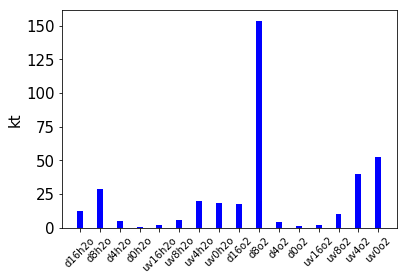

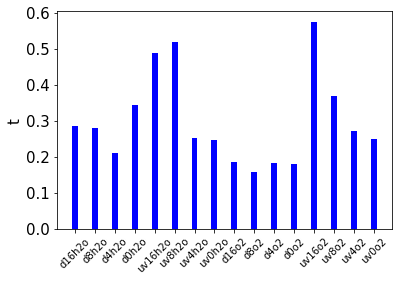

In [54]:
fitting_params = np.array(fitting_paramlist).T #transpose fitting parameters

rvalues = 1- np.sqrt(rsquarelist) #find r values for uncertainty  
uncertainties = np.multiply(rvalues, fitting_params)

for i in range(len(fitting_params)):
    #plt.errorbar(np.arange(len(names)), fitting_params[i], yerr=uncertainties[i], fmt='o', capthick=2)
    plt.bar(np.arange(len(names)), fitting_params[i], width=0.3, color='b', align='center', alpha=1)
    plt.xticks(np.arange(len(names)), names, rotation=45, size=10) #set x-value names
    plt.ylabel(func_vars[fitting_function.name][i], fontsize=15)
    plt.show()

In [58]:
fitting_params

array([[  12.32775103,   28.68132818,    5.25465687,    0.33348341,
           2.00083222,    5.96385485,   20.12277256,   18.23848958,
          18.01406894,  153.78612014,    4.25841741,    1.2599071 ,
           1.73508722,   10.42609274,   39.98079222,   52.66412716],
       [   0.28622026,    0.27907782,    0.21066154,    0.34407319,
           0.48672093,    0.51851752,    0.25093556,    0.24610714,
           0.18452165,    0.15860639,    0.18228026,    0.17890837,
           0.5747603 ,    0.36865469,    0.27121825,    0.24877651]])

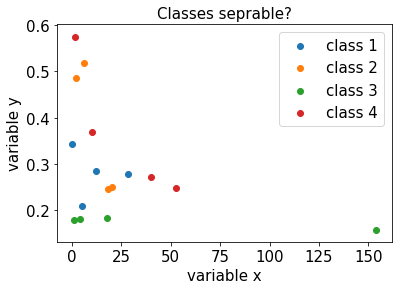

In [63]:
classnumber = 4 #number of distinct environonments or "classes"
for i in range(0,len(fitting_params[0]),classnumber):
    plt.scatter(fitting_params[0][i:i+classnumber],fitting_params[1][i:i+classnumber],
                label='class ' + format(1+int((i/classnumber))))
plt.title('Classes seprable?', fontsize=15)
plt.xlabel('variable x', fontsize=15); plt.ylabel('variable y', fontsize=15)
plt.legend(fontsize=15)
plt.show()